In [1]:
import os
import csv
import shutil
import random

In [14]:
directoryone = "daps_Data\\Class_One\\Spectrograms"
directorytwo = "daps_Data\\Class_Two\\Spectrograms"
for filename in os.listdir(directoryone):
    if 'f10' in filename:
        fullpath = os.path.join(directoryone, filename)
        shutil.move(fullpath, directorytwo)

Dzielimy dataset na dane do trenowania i testowania, wybieramy losowe 1000 losowych spektrogramów, zachowując proporcje między klasami

In [18]:
test_directory = "daps_Data\\test_dataset\\Images"
training_directory = "daps_Data\\training_dataset\\Images"
directoryone = "daps_Data\\Class_One\\Spectrograms"
directorytwo = "daps_Data\\Class_Two\\Spectrograms"
i = 1
a = random.sample(range(1, 1968), 300)
for filename in os.listdir(directoryone):
    fullpath = os.path.join(directoryone, filename)
    if i in a:
        shutil.copy(fullpath, test_directory)        
    else:
        shutil.copy(fullpath, training_directory)
    i=i+1
i=1
a = random.sample(range(1, 4464), 700)
for filename in os.listdir(directorytwo):
    fullpath = os.path.join(directorytwo, filename)
    if i in a:
        shutil.copy(fullpath, test_directory)        
    else:
        shutil.copy(fullpath, training_directory)
    i=i+1

Tworzymy plik csv opisujący, do której klasy należy spektrogram.

In [22]:
# name of csv file
csvname = "daps_Data\\training_dataset\\labels.csv"
class_one_indicators = ['f1', 'f7', 'f8', 'm3', 'm6', 'm8']
directory = "daps_Data\\training_dataset\\images"
# writing to csv file
with open(csvname, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
    for filename in os.listdir(directory):
        if any(indicator in filename for indicator in class_one_indicators) and not 'f10' in filename:
            csvwriter.writerow([filename, '1'])
        else:
            csvwriter.writerow([filename, '0'])        

In [2]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

Tworzymy klasę dla customowego datasetu

In [3]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
import torch
import torchvision
import torchvision.transforms.v2
import torchvision.transforms as transforms

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Stworzenie naszych datasetów

In [132]:
transform = torchvision.transforms.v2.Compose([transforms.Resize((193, 388)),transforms.v2.ToImage(),\
                                               transforms.v2.ToDtype(torch.float32, scale=True),\
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = ImageDataset(annotations_file = "..\\work_folder\\daps_Data\\Spectrograms2_cropped_training\\labels.csv", img_dir = "..\\work_folder\\daps_Data\\Spectrograms2_cropped_training\\Images"\
                       , transform = transform)

testset = ImageDataset(annotations_file = "..\\work_folder\\daps_Data\\Spectrograms2_cropped_test\\labels.csv", img_dir = "..\\work_folder\\daps_Data\\Spectrograms2_cropped_test\\Images"\
                      , transform = transform)

In [133]:
EPOCHS = 10  # Adjust based on training speed
LEARNING_RATE = 0.001  # Assuming square images, resize to 64x64
NUM_CLASSES = 2  # Change this based on your dataset

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)
classes = ("0", "1")

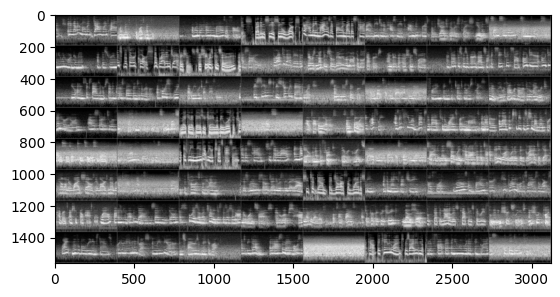

1     1     0     0     0     0     0     0     0     1     0     1     1     0     0     0     1     0     1     0     0     0     0     1     0     1     0     0     0     0     1     0     0     0     0     0     1     0     0     0     0     1     1     1     0     0     0     1     1     0     1     0     0     0     0     1     1     0     0     0     0     0     0     0    


In [134]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Tworzenie sieci

In [91]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 64, 64)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 32, 32)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (N, 64, 32, 32)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (N, 128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (N, 128, 8, 8)
        )
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x



net = Net(num_classes=NUM_CLASSES).to(DEVICE)
print(net)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc_layers): Sequential(
    (0): Fla

Trenowanie modelu

In [139]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [141]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.625
[1,    20] loss: 0.617
[1,    30] loss: 0.630
[1,    40] loss: 0.615
[1,    50] loss: 0.597
[1,    60] loss: 0.604
[1,    70] loss: 0.607
[1,    80] loss: 0.641
[1,    90] loss: 0.622
[1,   100] loss: 0.599
[1,   110] loss: 0.614
[1,   120] loss: 0.628
[1,   130] loss: 0.617
[1,   140] loss: 0.610
[1,   150] loss: 0.615
[1,   160] loss: 0.624
[1,   170] loss: 0.598
[1,   180] loss: 0.580
[1,   190] loss: 0.571
[1,   200] loss: 0.591
[1,   210] loss: 0.590
[1,   220] loss: 0.557
[1,   230] loss: 0.528
[1,   240] loss: 0.567
[1,   250] loss: 0.608
[1,   260] loss: 0.577
[1,   270] loss: 0.566
[1,   280] loss: 0.501
[1,   290] loss: 0.557
[1,   300] loss: 0.568
[1,   310] loss: 0.528
[1,   320] loss: 0.560
[1,   330] loss: 0.489
[1,   340] loss: 0.505
[1,   350] loss: 0.463
[1,   360] loss: 0.463
[1,   370] loss: 0.422
[1,   380] loss: 0.432
[1,   390] loss: 0.423
[1,   400] loss: 0.418
[1,   410] loss: 0.393
[1,   420] loss: 0.365
[1,   430] loss: 0.394
[1,   440] 

In [138]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 64, 64)
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 32, 32)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (N, 64, 32, 32)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 64, 16, 16)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (N, 128, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (N, 128, 8, 8)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(147456, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x



net = Net(num_classes=NUM_CLASSES).to(DEVICE)
print(net)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=147456, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )

In [142]:
PATH = '../work_folder/model_8.pth'

In [143]:
torch.save(net.state_dict(), PATH)

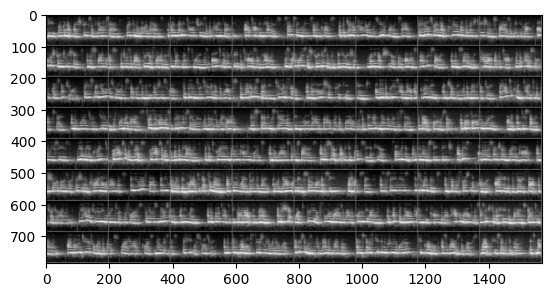

GroundTruth:  0     0     0     0    


In [123]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [144]:
net = Net(2)
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Testowanie naszego modelu

In [122]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  0     1     0     1    


In [145]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 test images: {100 * correct // total} %')

Accuracy of the network on the 1000 test images: 95 %


In [146]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 96.2 %
Accuracy for class: 1     is 93.4 %


Obliczenia F1

In [4]:
# Calculate precision, recall, and F1 score for class 0
true_positive_0 = 625
false_positive_0 = 95
false_negative_0 = 75

precision_0 = true_positive_0 / (true_positive_0 + false_positive_0)
recall_0 = true_positive_0 / (true_positive_0 + false_negative_0)
f1_score_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)

# Calculate precision, recall, and F1 score for class 1
true_positive_1 = 205
false_positive_1 = 75 
false_negative_1 = 95

precisioaan_1 = true_positive_1 / (true_positive_1 + false_positive_1)
recall_1 = true_positive_1 / (true_positive_1 + false_negative_1)
f1_score_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)

# Calculate macro average F1 score
macro_avg_f1_score = (f1_score_0 + f1_score_1) / 2

macro_avg_f1_score

0.7818075117370893